# Recurrent Neural Newtork para a previsão dos dados do INMET (3 a 3)

Rede neural RNN com função sigmoide para a previsão da variável target "PRECIPITAÇÃO TOTAL, HORÁRIO (mm)"

## Imports

In [1]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import numpy as np

2025-05-22 22:24:38.683053: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 22:24:38.690660: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-22 22:24:38.709556: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747963478.745145   36259 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747963478.753503   36259 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747963478.779407   36259 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

In [2]:
df = pd.read_csv("Banco de dados/inmet_filtrado.csv", index_col=0)

## Preparo dos dados

### Normalização (Por mínimo e máximo)

O código abaixo é aplicado column-wise

In [3]:
df_norm=(df-df.min())/(df.max()-df.min())

In [4]:
df_norm.head(2)

,"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",RADIACAO GLOBAL (Kj/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)","UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, RAJADA MAXIMA (m/s)"
datetime,,,,,
2021-01-01 14:00:00,0.0,0.315581,0.738095,0.705128,0.082988
2021-01-01 16:00:00,0.0,0.446617,0.742857,0.717949,0.228216


### Filtragem e dicotomização do modelo para precipitação

In [5]:
filtrar_ = lambda value: int(value != 0)

In [6]:
features = list(df_norm.columns[1:])
conj_x = df_norm[features]
y = df_norm[df_norm.columns[0]]
y = y.apply(filtrar_)

Já separa treino do teste!

In [7]:
conj_x_train, conj_x_test, y_train, y_test = train_test_split(conj_x, y, test_size=0.25, random_state=42)

In [44]:
def create_sequences(data, labels, time_steps=4):
    x, y = [], []
    for i in range(0, len(data) - time_steps, time_steps):
        x.append(data.iloc[i:i+time_steps])
        y.append(labels.iloc[i:i+time_steps])
    return np.array(x), np.array(y)

x_train_seq, y_train_seq = create_sequences(conj_x_train, y_train, time_steps=4)
x_test_seq, y_test_seq = create_sequences(conj_x_test, y_test, time_steps=4)

In [45]:
y_train_seq[0]

array([0, 0, 1, 1])

## Treino do RNN

### Criação do modelo

In [52]:
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(12, return_sequences=True, input_shape=(4,4))) # 4 timestep, 3 features
model.add(keras.layers.SimpleRNN(24))
model.add(keras.layers.Dropout(0.1))
model.add(keras.layers.Dense(4, activation="sigmoid"))
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 4, 12)          │           204 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_7 (SimpleRNN)        │ (None, 24)             │           888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,192 (4.66 KB)

 Trainable params: 1,192 (4.66 KB)

 Non-trainable params: 0 (0.00 B)

### Treino do modelo

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
history = model.fit(x_train_seq, y_train_seq,
                    epochs=80, validation_data=(x_test_seq, y_test_seq), callbacks=[early_stopping])

Epoch 1/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.3492 - loss: 0.4525 - val_accuracy: 0.1710 - val_loss: 0.3944
Epoch 2/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2064 - loss: 0.4006 - val_accuracy: 0.3040 - val_loss: 0.3855
Epoch 3/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3060 - loss: 0.3727 - val_accuracy: 0.4537 - val_loss: 0.3716
Epoch 4/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4240 - loss: 0.3701 - val_accuracy: 0.3634 - val_loss: 0.3615
Epoch 5/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3604 - loss: 0.3607 - val_accuracy: 0.3919 - val_loss: 0.3513
Epoch 6/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3770 - loss: 0.3608 - val_accuracy: 0.4204 - val_loss: 0.3435
Epoch 7/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3562 - loss: 0.3507 - val_accuracy: 0.4133 - val_loss: 0.3367
Epoch 8/80
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3912 - loss: 0.3328 - val_accuracy: 0.4228 - val_loss

Treino vs. Acurácia!

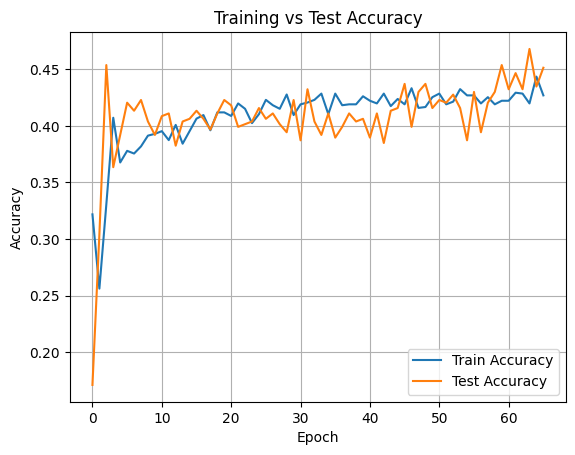

In [54]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## Predição

In [55]:
y_pred_prob = model.predict(x_test_seq)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [56]:
y_pred = (y_pred_prob > 0.5).astype(int)

In [57]:
for true, pred in zip(y_test[:10], y_pred[:10]):
    print(f"True: {true} - Predicted: {pred[0]}")

True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 0 - Predicted: 0
True: 1 - Predicted: 0


In [59]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test[:421], y_pred))
print(confusion_matrix(y_test[:421], y_pred))


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets